## Food delivery time prediction

### Introduction
The setup of challange establishes the task of developing a model that can predict expected time of arrival of executive to deliver the order. The target/dependent variable is of continous type and hence the task is of regression paradigm. We are provided with historical records of order deliviries in form of text file exports.

### Schema of Data
The data provided is present as text files where each file consists of data associated with an order in form of key-value pairs segregated over the lines. Key represents attribute and value is the associated value of the attribute. It is possible that all attributes are not present in a file. <br>
Following are all possible attributes:
<ul>
            <li>ID</li>                         
            <li>Delivery_person_ID</li>         
            <li>Delivery_person_Age</li>        
            <li>Delivery_person_Ratings</li>    
            <li>Restaurant_latitude</li>        
            <li>Restaurant_longitude</li>       
            <li>Delivery_location_latitude</li> 
            <li>Delivery_location_longitude</li>
            <li>Order_Date</li>                 
            <li>Time_Orderd</li>                
            <li>Time_Order_picked</li>          
            <li>Weather conditions</li>         
            <li>Road_traffic_density</li>
            <li>Vehicle_condition</li>          
            <li>Type_of_order</li>              
            <li>Type_of_vehicle</li>            
            <li>multiple_deliveries</li>        
            <li>Festival</li>                
            <li>City</li>                       
            <li>Time_taken (min)</li> 
</ul>
<b>Time_taken (min)</b> is target variable.<br>
There are 47880 training records and 9112 records in evaluation set.

### Approach
<ol>
    <li><b><u>Preprocessing </u>: </b> The data provided is segregated into text files which needs to be consolidated into single dataframe on which denoise and feature engineering can be applied to make data suitable for model iteration. Following operations has been performed as part of preprocessing:
        <ul>
            <li>Read the data files and consolidate into single dataframe.</li>
            <li>Data type of attribute values are converted to match the value domain.</li>
            <li>String encoding is performed i.e. if count of unique values is less than or equal to two then indices are assigned to each distinct values otherwise ohe-hot encoding is performed.</li>
            <li>Date type columns are transformed into integer columns by morphing dates (YYYY-MM-DD) into YYYY * 10000 + MM * 100 + DD (YYYYMMDD).</li>
            <li>Time columns are transformed into minutes.</li>
            <li>Missing data imputation is performed on numeric columns.</li>
            <li>"Delivery_person_Age" and "multiple_deliveries" is casted from float to integer as intrinsically these values should be belonging to integer domain.</li>
        </ul>
    </li>
    <li><b><u>Feature Selection </u>: </b> Lasso and Random Forest Regressor models are tuned to perform feature selection. The models allocate coefficients or feature importances which is filtered for the threshold value. The feature having coefficient/feature importance value greater than or equal to threshold is selected otherwise neglected.<br>Threshold = MEAN(FEATURE_IMPORTANCES | COEFFICIENTS) + 2 * STANDARD_DEVIATION(FEATURE_IMPORTANCES | COEFFICIENTS)</li>
    <li><b><u>Model Iteration </u>: </b> The experiments are planned to be executed on following models both with and without hyper parameter tuning:
        <ul>
            <li>Extended Gradient Boosting (XGB) Regressor</li>
            <li>Light Gradient Boosting (LGB) Regressor</li>
            <li>CatBoost Regressor</li>
            <li>Support Vector Machine (SVM) Regressor</li>
        </ul>
    </li>
</ol>

### Evaluation Metric
The performance metric for this challange is 100 * R^2_score(Prediction, Actual) which we need to maximize. 

In [2]:
# Library imports

import os
from datetime import datetime

# Preprocessing utility libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Library used in Feature Selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, make_scorer, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

# Models 
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR

# Clean up of cluttered warning messages
from warnings import filterwarnings

# Visualization
from matplotlib import pyplot as plt 

filterwarnings('ignore')

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [3]:
# initialize the environment
if(not os.path.exists('Logs')):
    # make logging directory where all metric log files in csv format will be stored.
    !mkdir Logs 
if(not os.path.exists('output_files')):
    # makes output_files directory which will hold all the files generated from the model predictions.
    !mkdir output_files

In [4]:
class MetricLogger:
    '''
    Description : This class acts as handler for logging and tracking experiments executed on daily basis with variations. 
    Final log will be saved as CSV file with experiment title and corresponding R2 score, RMSE and MAE metrics of models 
    specific to a variation. Here variation is made both at preprocessing stage and model iteration stage which are 
    tracked.
    '''
    def __init__(self):
        '''
        Description : This is constructor method which initializes the output log file name and the logger object in which 
        metrics will be saved against corresponding experiment title.
        '''
        self.file_name = './Logs/'+ datetime.now().strftime("%d%B%Y") + "_MetricLog.csv"
        
        self.log = {
                "Experiment_Title"  : [],
                "R2_Score" : [],
                "RMSE" : [],
                "MAE" : [],

            }

        if os.path.exists(self.file_name) == True:
            log_existing = pd.read_csv(self.file_name).to_dict()
            for key in log_existing.keys():
                self.log[key].extend(list(log_existing[key].values()))
            print(self.log)

    def logMetric(self, title, r2_value, rmse_value, mae_value):
        '''
        Description : This is main driver of the class which when supplied with the data/metric it saved it into the logger 
        object.

        Inputs : 
            title (String)  => It is the qualified description of the experiment enumerating variations adopted.
            r2_value (Float) => R2 score of the variant. This helps in tracking the explained variance of the experiment.
            rmse_value (Float) => Root Mean Squared Error between prediction and actual value for the variant.
            mae_value (Float) => Mean Absolute Error between prediction and actual value for the variant.
        '''
        self.log["Experiment_Title"].append(title)
        self.log["R2_Score"].append(r2_value)
        self.log["RMSE"].append(rmse_value)
        self.log["MAE"].append(mae_value)
    def saveLog(self):
        '''
        Description : This method when invoked, saves the dictionary (logger object) in CSV format.
        '''
        pd.DataFrame(self.log).to_csv(self.file_name, index=False) 

In [5]:
class HyperParameterTuner:
    '''
    Description : This class handles the hyper parameter tuning of models by performing cross validated grid search
    over the parameter space supplied/chosen by the user.
    '''
    def Tune(self, model, parameters, X, Y):
        '''
        Description : When this method is invoked with supplied parameters then grid search over parameter space is 
        performed to find the best set of parameters for the model that can optimize the scoring criterion.

        Inputs :
            model (Object) => The Machine Learning model instance for which best set of parameters needs to deduced.
            parameters (Dictionary) => This defines the parameter space on which the search needs to be performed.
            X (N-Dimensional Array) => The set of indepedent variable/features.
            Y (1-Dimensional Array) => The set of dependent variable/target. 
        Output : 
            best_params_ (Dictionary) => The parameters that resulted in optimal score is returned.
        '''
        print("Tuning model...")
        model_tuner = GridSearchCV(model, parameters, n_jobs = -1, cv=3, scoring = 'r2', verbose=3)
        model_tuner.fit(X, Y)
        print("Model Tuned!")
        return model_tuner.best_params_

In [6]:
class FeatureSelection:
    '''
    Description : The handler class for automated feature selection. The model based feature selection is performed to
    carve out list of features which may lead to optimal performance interms of metric value. The model is tuned and 
    trained on the data and then corresponding feature importances are features are filtered based on the threshold 
    value of feature importances. The features with feature importance less than threshold are neglected otherwise 
    is selected. There are two options to choose from viz., we can tune and train Lasso model and compute coefficients 
    which acts as feature importances or we can tune or train random forest model which directly provides feature 
    importances which can further filtered on threshold value. 
    '''
    def __init__(self, normalize = True):
        '''
        Description : The constructor method which initializes the object for hyperparameter tuning and flag value
        for choice to either normalize or not the feature values.

        Inputs : 
            normalize (Boolean) => The flag representing the choice of user wheather to apply normalization or not on
            feature values.
        '''
        self.hpt_engine = HyperParameterTuner()
        self.normalize = normalize
    def lasso(self, data, feature_columns, target_column):
        '''
        Description : This method tunes and trains Lasso model on the data. The coefficients obtained from the model is 
        filtered on the threshold values to obtain set of features.

        Inputs:
            data (Pandas Dataframe) => The potential set of features and target are present in the data.
            feature_columns (list) => The list of potential feature names that can act as independent variable.
            target_column (String) => The name of target column.
        Outut : 
            features (list) => List of filtered out features that reulted out of tuned Lasso model.
        '''
        model = Lasso(random_state=45)
        parameter_space = {
            "alpha" : [i for i in np.linspace(0,1,100)],
            "fit_intercept" : [True, False]
        }
        if self.normalize == True:
            scaler = StandardScaler()
            X = scaler.fit_transform(data[feature_columns])
        else:
            X = data[feature_columns]
        best_parameters = self.hpt_engine.Tune(model, parameter_space, X, data[target_column])
        model.set_params(**best_parameters)
        model.fit(X, data[target_column])
        feature_importances = np.abs(np.array(model.coef_))
        n = 2
        threshold = np.mean(feature_importances) - n * np.std(feature_importances)
        if np.max(feature_importances) >= threshold:
            features=np.array(feature_columns)[feature_importances >= threshold]
        else:
            features=np.array(feature_columns)
        print(f"Selected features are : {', '.join(list(features))}")
        return list(features)
    def random_forest(self, data, feature_columns, target_column):
        '''
        Description : This method tunes and trains Random Forest model on the data. The feature importances obtained 
        from the model is filtered on the threshold values to obtain set of features.

        Inputs:
            data (Pandas Dataframe) => The potential set of features and target are present in the data.
            feature_columns (list) => The list of potential feature names that can act as independent variable.
            target_column (String) => The name of target column.
        Outut : 
            features (list) => List of filtered out features that reulted out of tuned Random Forest model.
        '''
        model = RandomForestRegressor(random_state=45)
        parameter_space = {
            "n_estimators" : [100, 200, 300],
            "criterion" : ["mse","mae"],
            "max_features" : ["auto","sqrt","log2"]
        }
        scaler = StandardScaler()
        best_parameters = self.hpt_engine.Tune(model, parameter_space, scaler.fit_transform(data[feature_columns]), data[target_column])
        model.set_params(**best_parameters)
        model.fit(scaler.transform(data[feature_columns]), data[target_column])
        feature_importances = np.abs(np.array(model.feature_importances_))
        n = 2
        threshold = np.mean(feature_importances) - n * np.std(feature_importances)
        if np.max(feature_importances) >= threshold:
            features=np.array(feature_columns)[feature_importances >= threshold]
        else:
            features=np.array(feature_columns)
        print(f"Selected features are : {', '.join(list(features))}")
        return list(features)
        

In [7]:
class Preprocessing:
    '''
    Description : The preprocessing module is encapsulated in this class. Various preprocessing steps that data needs to be
    passed through are develoed and integrated as methods.
    '''
    def __init__(self, train_folder, test_folder):
        '''
        Description : The constructor initializes the object of scaler and feature selection module and invokes the 
        data transformation methods sequencially.

        Inputs : 
            train_folder (String) => The path of folder containg text files to be used for training of predictive model.
            test_folder (String) => The path of folder containg text files for hackerearth evaluation.
        '''
        self.scaler = StandardScaler()
        self.feature_selection_model = FeatureSelection()
        self.train_data = self.read_data(train_folder)
        self.test_data = self.read_data(test_folder)
        self.train_data = self.type_conversion(self.train_data)
        self.test_data = self.type_conversion(self.test_data)
        self.train_data = self.string_encoding(self.train_data)
        self.test_data = self.string_encoding(self.test_data)
        self.train_data = self.createYearMonthDay(self.train_data)
        self.test_data = self.createYearMonthDay(self.test_data)
        self.train_data = self.createHourMinute(self.train_data)
        self.test_data = self.createHourMinute(self.test_data)
        self.train_data = self.createResponseTimeFeature(self.train_data)
        self.test_data = self.createResponseTimeFeature(self.test_data)
        self.train_data = self.missingDataImputation(self.train_data)
        self.test_data = self.missingDataImputation(self.test_data, mode=1)
        self.train_data = self.adjustTypes(self.train_data)
        self.test_data = self.adjustTypes(self.test_data)
    def read_data(self, path):
        '''
        Description : This method reads the individual text files present in the provided path and consolidates it into
        pandas Dataframe.

        Inputs:
            path (String) => The path of folder containing the text files with line segregated key-value pairs (seperated by spaces).
        Output:
            data (Pandas Dataframe) => The consolidated data from all the text files present in the provided folder path.
        '''
        data = {
            "ID" : [],                         
            "Delivery_person_ID" : [],         
            "Delivery_person_Age" : [],        
            "Delivery_person_Ratings" : [],    
            "Restaurant_latitude" : [],        
            "Restaurant_longitude" : [],       
            "Delivery_location_latitude" : [], 
            "Delivery_location_longitude" : [],
            "Order_Date" : [],                 
            "Time_Orderd" : [],                
            "Time_Order_picked" : [],          
            "Weather conditions" : [],         
            "Road_traffic_density" : [],
            "Vehicle_condition" : [],          
            "Type_of_order" : [],              
            "Type_of_vehicle" : [],            
            "multiple_deliveries" : [],        
            "Festival" : [],                
            "City" : [],                       
            "Time_taken (min)"  : [] 
        }
        for file in os.listdir(path):
            with open(path + file, 'r') as data_file:
                raw_data = data_file.read()
            lines = raw_data.split('\n')
            is_available = {
            "ID" : False,                         
            "Delivery_person_ID" : False,         
            "Delivery_person_Age" : False,        
            "Delivery_person_Ratings" : False,    
            "Restaurant_latitude" : False,        
            "Restaurant_longitude" : False,       
            "Delivery_location_latitude" : False, 
            "Delivery_location_longitude" : False,
            "Order_Date" : False,                 
            "Time_Orderd" : False,                
            "Time_Order_picked" : False,          
            "Weather conditions" : False,         
            "Road_traffic_density" : False,
            "Vehicle_condition" : False,          
            "Type_of_order" : False,              
            "Type_of_vehicle" : False,            
            "multiple_deliveries" : False,        
            "Festival" : False,                
            "City" : False,                       
            "Time_taken (min)"  : False 
            }
            for n_line in range(len(lines)-1):
                information = lines[n_line].split()
                key = ' '.join(information[:len(information)-1])
                value = information[-1]
                data[key].append(value)
                is_available[key] = True
            for column in is_available.keys():
                if is_available[column] == False:
                    data[column].append(np.nan)
        return pd.DataFrame(data)
    
    def type_conversion(self, data):
        '''
        Description : This method is responsible for converting the data types of attributes of data into suitable data type
        such that type matches the value domain of the attribute's data.

        Input:
            data (Pandas Dataframe) => The data with consolidated records from text files.
        Output:
            data (Pandas Dataframe) => The typecasted data
        '''
        data_type_mapping = {
            "ID" : "str",                         
            "Delivery_person_ID" : "str",         
            "Delivery_person_Age" : "float",        
            "Delivery_person_Ratings" : "float",    
            "Restaurant_latitude" : "float",        
            "Restaurant_longitude" : "float",       
            "Delivery_location_latitude" : "float", 
            "Delivery_location_longitude" : "float",
            "Order_Date" : "date",                 
            "Time_Orderd" : "str",                
            "Time_Order_picked" : "str",          
            "Weather conditions" : "str",         
            "Road_traffic_density" : "str",
            "Vehicle_condition" : "int",          
            "Type_of_order" : "str",              
            "Type_of_vehicle" : "str",            
            "multiple_deliveries" : "float",        
            "Festival" : "str",                
            "City" : "str",                       
            "Time_taken (min)"  : "float" 
        }
        for column in data_type_mapping.keys():
            if data_type_mapping[column] not in ["date","time"] and column in data:
                if column in ["Time_Orderd","Time_Order_picked"]:
                    data[column].fillna('00:00', inplace=True)
                    data[column] = data[column].replace({'NaN' : '00:00'})
                data[column] = data[column].astype(data_type_mapping[column])
            if data_type_mapping[column] in ["date","time"] and column in data:
                data[column] = pd.to_datetime(data[column], infer_datetime_format=True, errors='ignore')
        return data
    
    def string_encoding(self, data):
        '''
        Description : This method takes care of numeric mapping for string type columns. If count of unique values in a 
        column is <=2 then each distinct value is mapped with the unique integer index otherwise, one-hot encoding is 
        performed.

        Input:
            data (Pandas Dataframe) => The data with consolidated records from text files.
        Output:
            data (Pandas Dataframe) => The data with numeric mappings for string type columns.
        '''
        string_feature_columns = [
            'Weather conditions',
            'City',
            'Festival',
            'Type_of_vehicle',
            'Type_of_order',
            'Road_traffic_density'
        ]
        for column in string_feature_columns:
            data[column] = data[column].fillna('na')
            data[column] = data[column].str.lower()
            data[column].replace({"nan" : "na"}, inplace=True)
            if data[column].nunique() <=2:
                distinct = list(data[column].unique())
                mapping = {distinct[i] : i for i in range(len(distinct))}
                print(f"The mapping for {column} is {mapping}")
                data[column] = data[column].replace(mapping)
            else:
                data = pd.get_dummies(data, columns = [column])
        return data
    
    def adjustTypes(self, data):
        '''
        Description : This method converts float type columns that have discrete values into integer type.

        Input:
            data (Pandas Dataframe) => The data with consolidated records from text files.
        Output:
            data (Pandas Dataframe) => The data with discrete valued columns typecasted into integer.
        '''
        integer_columns = [
            "Delivery_person_Age", 
            "multiple_deliveries"
            ]
        data[integer_columns] = data[integer_columns].round().astype('int')
        return data
    
    def createYearMonthDay(self, data):
        '''
        Description : The date type columns is converted into integer by applying below transformation.
            Transformation : Date (YYYY-MM-DD) -> Integer (YYYY * 10000 + MM * 100 + DD)

        Input:
            data (Pandas Dataframe) => The data with consolidated records from text files.
        Output:
            data (Pandas Dataframe) => The date with date transformation applied.
        '''
        year = data["Order_Date"].dt.year
        month = data["Order_Date"].dt.month
        day = data["Order_Date"].dt.day
        data.drop(columns=["Order_Date"], inplace=True)
        data["Order_Date"] = year * 10000 + month * 100 + day
        return data
     
    def createHourMinute(self, data):
        '''
        Description : The time columns are converted into minutes by applying below transformation.
            Transformation : Time (HH : MM) -> Integer (HH * 60 + MM)

        Input:
            data (Pandas Dataframe) => The data with consolidated records from text files.
        Output:
            data (Pandas Dataframe) => The data with transformed time columns.
        '''
        time_columns = [
            "Time_Orderd",
            "Time_Order_picked"
        ]
        for column in time_columns:
            data[column] = data[column].apply(lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]))
        return data
    
    def createResponseTimeFeature(self, data):
        '''
        Description : The feature engineered column is created by difference of time at which order is picked and time at
        which order is placed.

        Input:
            data (Pandas Dataframe) => The data with consolidated records from text files.
        Output:
            data (Pandas Dataframe) => The data with order placement and order pick time is replaced with single feature
            (Created by difference of the same).
        '''
        data['Response_Time'] = data['Time_Order_picked'] - data['Time_Orderd']
        data.drop(columns=["Time_Orderd","Time_Order_picked"], inplace=True)
        return data
    
    def missingDataImputation(self,data, mode=0):
        '''
        Description : The missing data (NaNs and None) is imputed/replaced with the suitable values. With suitable value, 
        the intent is to replace the missing records with values that suits the value domain of the column. 
        For Example :- "Delivery_person_Age" is of integer type and hence statistical mode of the column values will be 
        better representative than the statistical mean or median.

        Input:
            data (Pandas Dataframe) => The data with consolidated records from text files.
            mode (Binary Integer) => This defines whetaher the imputation is to be applieed for training data(mode = 0) or 
            test data(mode = 1).
        Output:
            data (Pandas Dataframe) => The data with no null records.
        '''
        data_type_mapping = {     
            "Delivery_person_Age" : "int",         # Changed as part of preprocessing
            "Delivery_person_Ratings" : "float",    
            "Restaurant_latitude" : "float",        
            "Restaurant_longitude" : "float",       
            "Delivery_location_latitude" : "float", 
            "Delivery_location_longitude" : "float",
            "Vehicle_condition" : "int",              
            "multiple_deliveries" : "int",   # Changed as part of preprocessing         
            "Time_taken (min)"  : "float" 
        }
        if mode == 0:
            for column in data_type_mapping.keys():
                if data_type_mapping[column] == 'float':
                    mean = data[column].mean()
                    data[column].fillna(mean, inplace=True)
                else:
                    mode = int(data[column].mode()[0])
                    data[column].fillna(mode, inplace=True)
        else:
            for column in list(set(data_type_mapping.keys()).difference(set(['Time_taken (min)']))):
                if data_type_mapping[column] == 'float':
                    mean = data[column].mean()
                    data[column].fillna(mean, inplace=True)
                else:
                    mode = int(data[column].mode()[0])
                    data[column].fillna(mode, inplace=True)
        return data
    
    def getX(self, require_feature_selection = True, apply_PCA = False,feature_selection_model='lasso', normalize = True):
        '''
        Description : This method is used to carve out features (either all or via feature selection) and provide the data 
        for independent variable. The data can further be processed to reduce the burden of compute by making use of PCA 
        (Principal Component Anlysis) for dimensionlity reduction and/(or) normalization of data.

        Input: 
            require_feature_selection (Boolean) => This flag represents the choice of user wheather to to filter out features 
            from feature selection module or use all the possible features available.
            apply_PCA (Boolean) => The flag of choice for applying PCA on the data to reduce the dimension or use the entire 
            width of data.
            feature_selection_model (String) => The name of model to be used for feature selection i.e "lasso" or "random_forest".
            normalize (Boolean) => Flag representing choice of whether to apply feature scaling or not.
        Output:
            train_data (Pandas Dataframe) => The preprocessed and filtered data which can directly be supplied to models from training set
            test_data (Pandas Dataframe) => The preprocessed and filtered data which can directly be supplied to models from test set.
        '''
        train_data = self.train_data
        test_data = self.test_data
        columns_to_exclude = [
            "ID",                       
            "Delivery_person_ID",               
            "Time_taken (min)" 
        ]
        feature_columns = list(set(train_data.columns).difference(set(columns_to_exclude)))
        if require_feature_selection:
            if feature_selection_model == 'lasso':
                feature_columns = self.feature_selection_model.lasso(train_data, feature_columns, "Time_taken (min)")
            elif feature_selection_model == 'random_forest':
                feature_columns = self.feature_selection_model.random_forest(train_data, feature_columns, "Time_taken (min)")
        if normalize:
            train_data = self.scaler.fit_transform(train_data[feature_columns])
            test_data = self.scaler.transform(test_data[feature_columns])
        else:
            train_data = train_data[feature_columns]
            test_data = test_data[feature_columns]
        
        if apply_PCA == True:
            pca = PCA(n_components = 'mle', whiten = True, svd_solver = 'auto', random_state = 45)
            train_data = pca.fit_transform(train_data)
            test_data = pca.transform(test_data)
        
        return train_data, test_data
    
    def getY(self):
        '''
        Description : This method returns the data for target column which will be used in training the predictive model.

        Output:
            target_data (Pandas Series) => The target data.
        '''
        return self.train_data['Time_taken (min)']
    
    def generate_submission_file(self, predictions, file_name, output_dir = './output_files/'):
        '''
        Description : The method is capable of generating output file in the submission format of the challange.

        Input:
            predictions (List) => The list of predictions generated from the model for evaluation set.
            file_name (String) => The file name of the output prediction file.
            output_dir (String) => The folder in which the output/submission file needs to be saved. 
        '''
        data = pd.DataFrame({
            "ID" : self.test_data['ID'].values,
            "Time_taken (min)" : predictions
        })
        data.to_csv(output_dir + file_name, index=False)

    def split_X_Y(self, X, Y):
        '''
        Description : The method splits the input data into 80:20 ratio where 80 percent split of the data belongs to training
        set and rest 20 percent belongs to validation set.

        Input : 
            X (Pandas Dataframe) => The data conataining features for model iteration.
            Y (Pandas Series) => The target data.
        Output : 
            X_train (Pandas Dataframe) => The training data with featueres.
            X_val (Pandas Dataframe) => The validation data with featueres.
            Y_train (Pandas Series) => Target data for training set.
            Y_val (Pandas Series) => Target data for validation set.
        '''
        X_train, X_val, Y_train, Y_val = train_test_split(X,Y,test_size=0.2,random_state=45,shuffle=True)
        return X_train, X_val, Y_train, Y_val
    
    def view_data(self):
        print("\n******** Train Data ********\n")
        display(self.train_data.head())
        display(self.train_data.tail())
        print("\n******** Test Data *********\n")
        display(self.test_data.head())
        display(self.test_data.tail())

In [8]:
metric_tracker = MetricLogger()

{'Experiment_Title': ['XGB Regressor with default parameters + Lasso based Feature Selection + Normalized Features', 'LGBM Regressor with default parameters + Lasso based Feature Selection + Normalized Features', 'CatBoost Regressor with default parameters + Lasso based Feature Selection + Normalized Features', 'Support Vector Machine Regressor with default parameters + Lasso based Feature Selection + Normalized Features', 'CatBoost Regressor with parameter tuning (learning_rate, border_count and depth) + Lasso based Feature Selection + Normalized Features', 'XGB Regressor with parameter tuning (n_estimator, learning_rate, max_depth, lambda, alpha) + Lasso based Feature Selection + Normalized Features', 'XGB Regressor with default parameters + Normalized Features', 'LGBM Regressor with default parameters + Normalized Features', 'CatBoost Regressor with default parameters + Normalized Features', 'Support Vector Machine Regressor with default parameters + Normalized Features', 'CatBoost 

In [9]:
preprocessing_engine = Preprocessing('dataset/train/','dataset/test/')

In [10]:
preprocessing_engine.view_data()


******** Train Data ********



ID Delivery_person_ID  ...  Order_Date  Response_Time
0  0x4607     INDORES13DEL02  ...    20220319             15
1  0xb379     BANGRES18DEL02  ...    20220325              5
2  0x5d6d     BANGRES19DEL01  ...    20220319             15
3  0x7a6a    COIMBRES13DEL02  ...    20220405             10
4  0x70a2     CHENRES12DEL01  ...    20220326             15

[5 rows x 40 columns]

ID Delivery_person_ID  ...  Order_Date  Response_Time
45588  0x7c09      JAPRES04DEL01  ...    20220324             10
45589  0xd641      AGRRES16DEL01  ...    20220216             15
45590  0x4f8d     CHENRES08DEL03  ...    20220311             15
45591  0x5eee    COIMBRES11DEL01  ...    20220307              5
45592  0x5fb2   RANCHIRES09DEL02  ...    20220302              5

[5 rows x 40 columns]


******** Test Data *********



ID Delivery_person_ID  ...  Order_Date  Response_Time
0  0x2318    COIMBRES13DEL01  ...    20220330            905
1  0x3474     BANGRES15DEL01  ...    20220329              5
2  0x9420      JAPRES09DEL03  ...    20220310             10
3  0x72ee      JAPRES07DEL03  ...    20220402              5
4  0xa759     CHENRES19DEL01  ...    20220327             15

[5 rows x 40 columns]

ID Delivery_person_ID  ...  Order_Date  Response_Time
11394  0x6909      JAPRES01DEL01  ...    20220327             10
11395  0x443b      JAPRES11DEL01  ...    20220311              5
11396  0x1ea5      SURRES11DEL03  ...    20220311           1265
11397  0x22d4      VADRES03DEL02  ...    20220306              5
11398  0xb7be     CHENRES07DEL02  ...    20220324              5

[5 rows x 40 columns]

In [11]:
preprocessing_engine.train_data.columns

Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Vehicle_condition',
       'multiple_deliveries', 'Time_taken (min)', 'Weather conditions_cloudy',
       'Weather conditions_fog', 'Weather conditions_na',
       'Weather conditions_sandstorms', 'Weather conditions_stormy',
       'Weather conditions_sunny', 'Weather conditions_windy',
       'City_metropolitian', 'City_na', 'City_semi-urban', 'City_urban',
       'Festival_na', 'Festival_no', 'Festival_yes', 'Type_of_vehicle_bicycle',
       'Type_of_vehicle_electric_scooter', 'Type_of_vehicle_motorcycle',
       'Type_of_vehicle_scooter', 'Type_of_order_buffet',
       'Type_of_order_drinks', 'Type_of_order_meal', 'Type_of_order_snack',
       'Road_traffic_density_high', 'Road_traffic_density_jam',
       'Road_traffic_density_low', 'Road_traffic_density_medium',
      

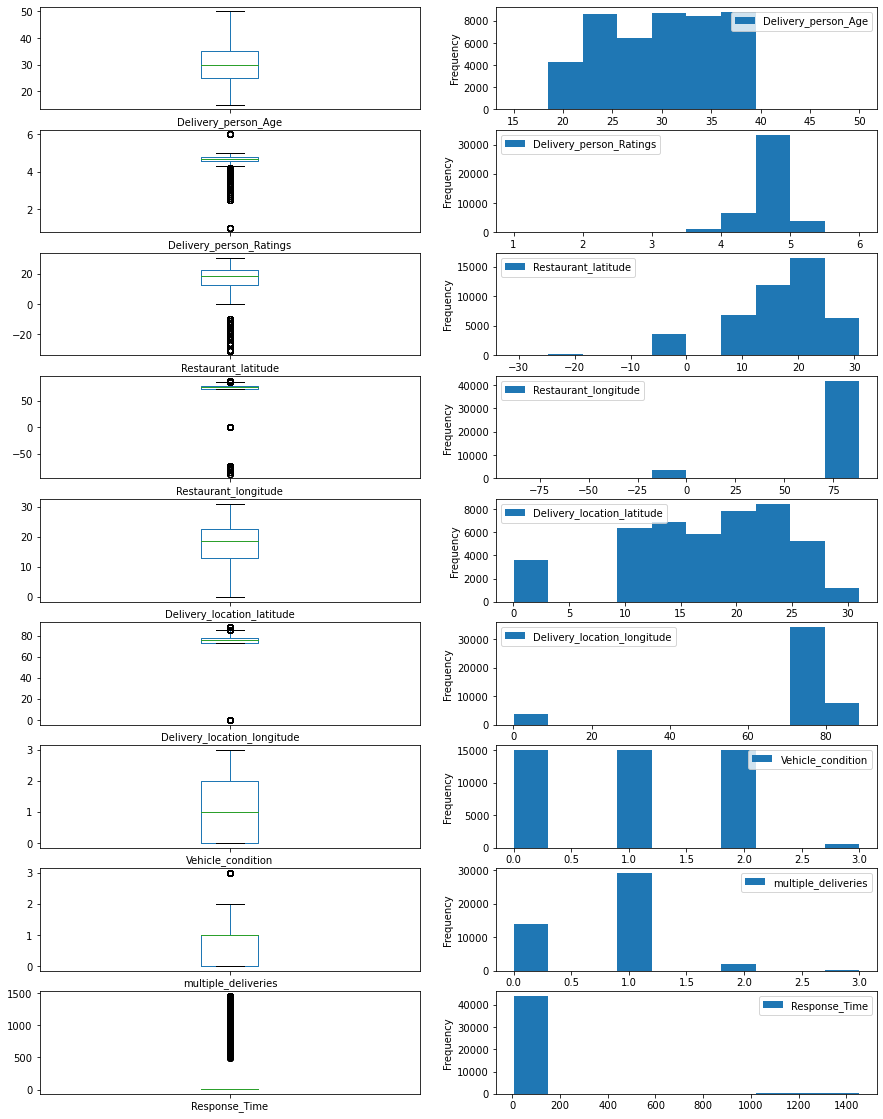

In [12]:
# Distribution of values.
columns_to_visualize = ['Delivery_person_Age','Delivery_person_Ratings','Restaurant_latitude','Restaurant_longitude','Delivery_location_latitude',
'Delivery_location_longitude','Vehicle_condition','multiple_deliveries','Response_Time']

fig, ax = plt.subplots(len(columns_to_visualize),2)

idx = 0 
for column in columns_to_visualize:
    preprocessing_engine.train_data.plot(
        y = column,
        x = 'Time_taken (min)',
        kind = 'box',
        ax = ax[idx,0],
        figsize = (15,20) 
        )
        
    preprocessing_engine.train_data.plot(
        y = column,
        x = 'Time_taken (min)',
        kind = 'hist',
        ax = ax[idx,1],
        figsize = (15,20)
        )
    idx += 1


<AxesSubplot:ylabel='column_name'>

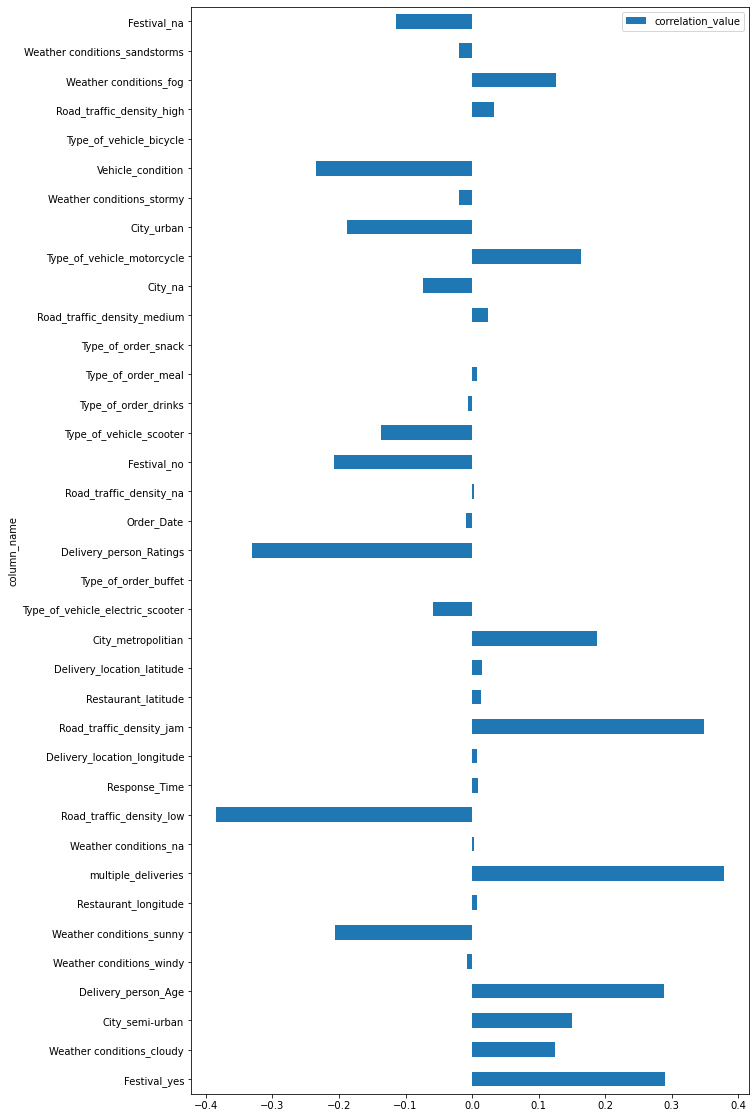

In [13]:
# correlation analysis.
feature_columns = list(set(preprocessing_engine.train_data.columns).difference(set(['ID', 'Delivery_person_ID', 'Time_taken (min)'])))
target_column = 'Time_taken (min)'
correlations = {"column_name" : [], "correlation_value" : []}  
for column in feature_columns:
    correlations['column_name'].append(column)
    correlations['correlation_value'].append(preprocessing_engine.train_data[column].corr(preprocessing_engine.train_data[target_column])) 
correlations = pd.DataFrame(correlations)
correlations.plot(
    x = 'column_name',
    y = 'correlation_value',
    kind = 'barh',
    figsize = (10,20)
)   

<AxesSubplot:title={'center':'Min response time'}, ylabel='Order_Date'>

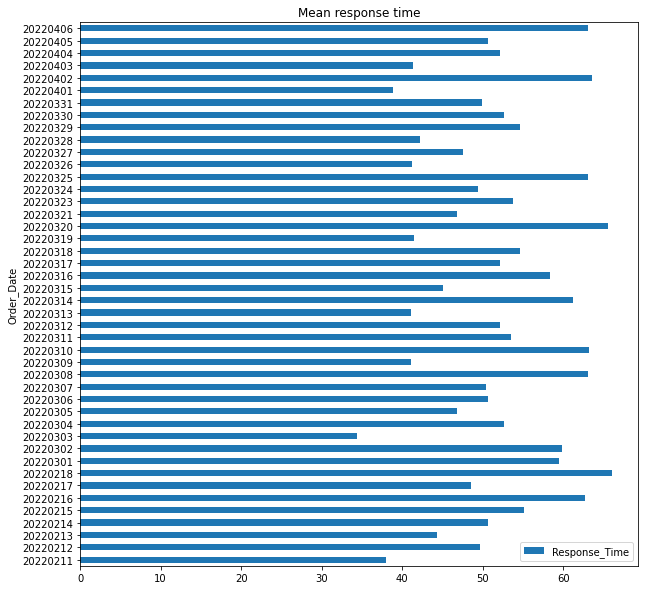

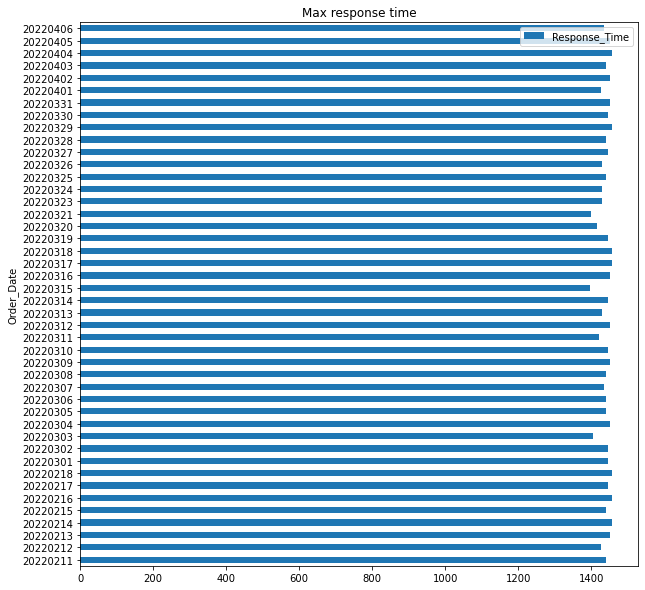

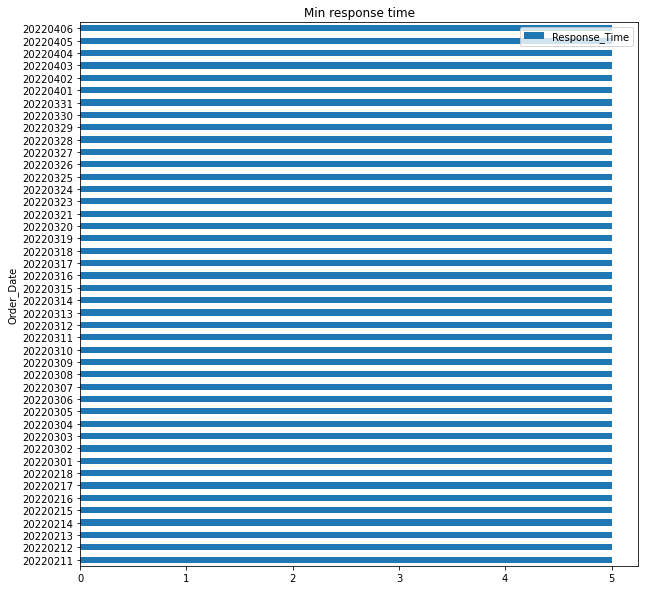

In [14]:
preprocessing_engine.train_data.groupby('Order_Date')['Response_Time'].mean().reset_index().plot(
    x = 'Order_Date',
    y = 'Response_Time',
    kind = 'barh',
    figsize = (10,10),
    title = "Mean response time", 
)
preprocessing_engine.train_data.groupby('Order_Date')['Response_Time'].max().reset_index().plot(
    x = 'Order_Date',
    y = 'Response_Time',
    kind = 'barh',
    figsize = (10,10),
    title = "Max response time"
)
preprocessing_engine.train_data.groupby('Order_Date')['Response_Time'].min().reset_index().plot(
    x = 'Order_Date',
    y = 'Response_Time',
    kind = 'barh',
    figsize = (10,10),
    title = "Min response time" 
)

In [15]:
X, X_test = preprocessing_engine.getX(require_feature_selection = True, apply_PCA = False, normalize = True)
Y = preprocessing_engine.getY()
variant = "Normalized Features"

Tuning model...
Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   23.7s finished


Model Tuned!
Selected features are : Festival_yes, Weather conditions_cloudy, City_semi-urban, Delivery_person_Age, Weather conditions_windy, Weather conditions_sunny, Restaurant_longitude, multiple_deliveries, Weather conditions_na, Road_traffic_density_low, Response_Time, Delivery_location_longitude, Road_traffic_density_jam, Restaurant_latitude, Delivery_location_latitude, City_metropolitian, Type_of_vehicle_electric_scooter, Type_of_order_buffet, Delivery_person_Ratings, Order_Date, Road_traffic_density_na, Festival_no, Type_of_vehicle_scooter, Type_of_order_drinks, Type_of_order_meal, Type_of_order_snack, Road_traffic_density_medium, City_na, Type_of_vehicle_motorcycle, City_urban, Weather conditions_stormy, Vehicle_condition, Type_of_vehicle_bicycle, Road_traffic_density_high, Weather conditions_fog, Weather conditions_sandstorms, Festival_na


In [16]:
X_train, X_val, Y_train, Y_val = preprocessing_engine.split_X_Y(X, Y)

R^2 score 0.7889716619943706


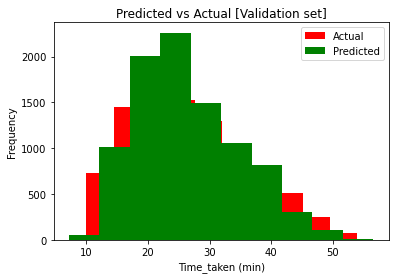

In [16]:
# XGB Regressor
model_xgb_raw = XGBRegressor(
    n_jobs = -1
)
model_xgb_raw.fit(X_train,Y_train)
predictions = model_xgb_raw.predict(X_val)
print(f"R^2 score {r2_score(Y_val,predictions)}")
metric_tracker.logMetric(
    "XGB Regressor with default parameters + "+variant, 
    r2_score(Y_val,predictions), 
    mean_squared_error(Y_val,predictions, squared=False), 
    mean_absolute_error(Y_val,predictions))
plt.ylabel('Frequency')
plt.xlabel('Time_taken (min)')
plt.title("Predicted vs Actual [Validation set]")
plt.hist(Y_val, bins = 10,color='red')
plt.hist(predictions, bins = 10, color='green')
plt.legend(['Actual','Predicted'], loc='upper right')
plt.show()
predictions = model_xgb_raw.predict(X_test)
preprocessing_engine.generate_submission_file(predictions,"XGB Regressor with default parameters + "+variant+".csv")

R^2 score 0.7711952230436783


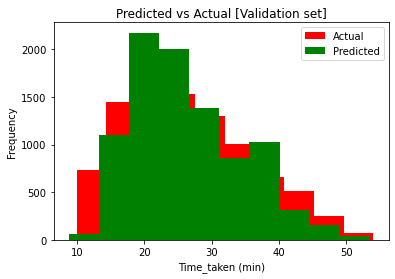

In [17]:
# LGBM Regressor
model_lgbm_raw = LGBMRegressor(
    n_jobs = -1
)
model_lgbm_raw.fit(X_train,Y_train)
predictions = model_lgbm_raw.predict(X_val)
print(f"R^2 score {r2_score(Y_val,predictions)}")
metric_tracker.logMetric(
    "LGBM Regressor with default parameters + "+variant, 
    r2_score(Y_val,predictions), 
    mean_squared_error(Y_val,predictions, squared=False), 
    mean_absolute_error(Y_val,predictions))

plt.ylabel('Frequency')
plt.xlabel('Time_taken (min)')
plt.title("Predicted vs Actual [Validation set]")
plt.hist(Y_val, bins = 10,color='red')
plt.hist(predictions, bins = 10, color='green')
plt.legend(['Actual','Predicted'], loc='upper right')
plt.show()
predictions = model_lgbm_raw.predict(X_test)
preprocessing_engine.generate_submission_file(predictions,"LGBM Regressor with default parameters + "+variant+".csv")

Learning rate set to 0.072272
0:	learn: 8.9609234	total: 189ms	remaining: 3m 8s
1:	learn: 8.6069376	total: 194ms	remaining: 1m 36s
2:	learn: 8.2812388	total: 199ms	remaining: 1m 6s
3:	learn: 7.9899561	total: 205ms	remaining: 51s
4:	learn: 7.7288857	total: 209ms	remaining: 41.6s
5:	learn: 7.4956610	total: 214ms	remaining: 35.4s
6:	learn: 7.2941682	total: 219ms	remaining: 31s
7:	learn: 7.0993931	total: 224ms	remaining: 27.7s
8:	learn: 6.9299424	total: 229ms	remaining: 25.2s
9:	learn: 6.7842739	total: 257ms	remaining: 25.4s
10:	learn: 6.6460314	total: 272ms	remaining: 24.4s
11:	learn: 6.5272123	total: 277ms	remaining: 22.8s
12:	learn: 6.4140860	total: 283ms	remaining: 21.5s
13:	learn: 6.3113065	total: 294ms	remaining: 20.7s
14:	learn: 6.2211004	total: 301ms	remaining: 19.7s
15:	learn: 6.1319109	total: 306ms	remaining: 18.8s
16:	learn: 6.0504366	total: 311ms	remaining: 18s
17:	learn: 5.9811005	total: 316ms	remaining: 17.3s
18:	learn: 5.9200365	total: 321ms	remaining: 16.6s
19:	learn: 5.861

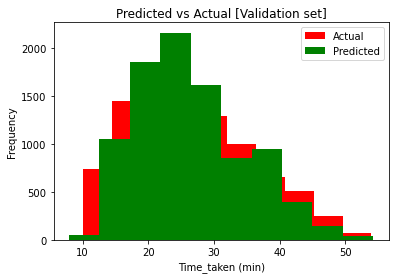

In [18]:
# CatBoost Regressor
model_catboost_raw = CatBoostRegressor()
model_catboost_raw.fit(X_train, Y_train)
predictions = model_catboost_raw.predict(X_val)
print(f"R^2 score {r2_score(Y_val,predictions)}")
metric_tracker.logMetric(
    "CatBoost Regressor with default parameters + "+variant, 
    r2_score(Y_val,predictions), 
    mean_squared_error(Y_val,predictions, squared=False), 
    mean_absolute_error(Y_val,predictions))
plt.ylabel('Frequency')
plt.xlabel('Time_taken (min)')
plt.title("Predicted vs Actual [Validation set]")
plt.hist(Y_val, bins = 10,color='red')
plt.hist(predictions, bins = 10, color='green')
plt.legend(['Actual','Predicted'], loc='upper right')
plt.show()
predictions = model_catboost_raw.predict(X_test)
preprocessing_engine.generate_submission_file(predictions,"CatBoost Regressor with default parameters + "+variant+".csv")

R^2 score 0.640350885489405


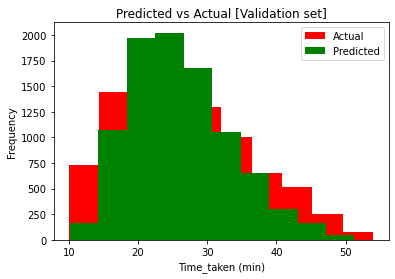

In [19]:
# Support Vector Machine Regressor
model_svr_raw = SVR()
model_svr_raw.fit(X_train, Y_train)
predictions = model_svr_raw.predict(X_val)
print(f"R^2 score {r2_score(Y_val,predictions)}")
metric_tracker.logMetric(
    "Support Vector Machine Regressor with default parameters + "+variant, 
    r2_score(Y_val,predictions), 
    mean_squared_error(Y_val,predictions, squared=False), 
    mean_absolute_error(Y_val,predictions))
plt.ylabel('Frequency')
plt.xlabel('Time_taken (min)')
plt.title("Predicted vs Actual [Validation set]")
plt.hist(Y_val, bins = 10,color='red')
plt.hist(predictions, bins = 10, color='green')
plt.legend(['Actual','Predicted'], loc='upper right')
plt.show()
predictions = model_svr_raw.predict(X_test)
preprocessing_engine.generate_submission_file(predictions,"Support Vector Machine Regressor with default parameters + "+variant+".csv")

0:	learn: 27.7951385	test: 28.1674308	best: 28.1674308 (0)	total: 4.09ms	remaining: 4.09s
1:	learn: 27.7693999	test: 28.1414653	best: 28.1414653 (1)	total: 7.53ms	remaining: 3.75s
2:	learn: 27.7436849	test: 28.1156049	best: 28.1156049 (2)	total: 10.6ms	remaining: 3.52s
3:	learn: 27.7180688	test: 28.0898765	best: 28.0898765 (3)	total: 13.9ms	remaining: 3.46s
4:	learn: 27.6924581	test: 28.0640399	best: 28.0640399 (4)	total: 16.9ms	remaining: 3.36s
5:	learn: 27.6671245	test: 28.0385257	best: 28.0385257 (5)	total: 20.1ms	remaining: 3.32s
6:	learn: 27.6421843	test: 28.0134292	best: 28.0134292 (6)	total: 23ms	remaining: 3.26s
7:	learn: 27.6171413	test: 27.9881930	best: 27.9881930 (7)	total: 26ms	remaining: 3.22s
8:	learn: 27.5919942	test: 27.9628233	best: 27.9628233 (8)	total: 29.2ms	remaining: 3.21s
9:	learn: 27.5666119	test: 27.9372536	best: 27.9372536 (9)	total: 32.1ms	remaining: 3.18s
10:	learn: 27.5414783	test: 27.9120101	best: 27.9120101 (10)	total: 35.3ms	remaining: 3.17s
11:	learn: 2

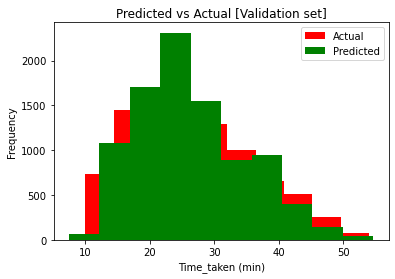

In [20]:
# CatBoost Regressor
model_catboost_tuned = CatBoostRegressor(loss_function = 'RMSE')
parameter_space = {
    "learning_rate" : [0.001,0.0001,0.01,0.1],
    "border_count" : [5, 10, 20, 50, 100],
    "depth" : [5,10,20, 50, 100]
}
model_catboost_tuned.grid_search(parameter_space,X_train, Y_train)
predictions = model_catboost_tuned.predict(X_val)
print(f"R^2 score {r2_score(Y_val,predictions)}")
metric_tracker.logMetric(
    "CatBoost Regressor with parameter tuning (learning_rate, border_count and depth) + "+variant, 
    r2_score(Y_val,predictions), 
    mean_squared_error(Y_val,predictions, squared=False), 
    mean_absolute_error(Y_val,predictions))
plt.ylabel('Frequency')
plt.xlabel('Time_taken (min)')
plt.title("Predicted vs Actual [Validation set]")
plt.hist(Y_val, bins = 10,color='red')
plt.hist(predictions, bins = 10, color='green')
plt.legend(['Actual','Predicted'], loc='upper right')
plt.show()
predictions = model_catboost_tuned.predict(X_test)
preprocessing_engine.generate_submission_file(predictions,"CatBoost Regressor with parameter tuning (learning_rate, border_count and depth) + "+variant+".csv")

In [21]:
hpt_engine = HyperParameterTuner()

Tuning model...
Fitting 3 folds for each of 900 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed: 30.5min
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed: 38.6min
[Parallel(n_jobs=-1)]: Done 2024 tasks      | elapsed: 55.2min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 65.4min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed: 78.5min finished


Model Tuned!
R^2 score 0.74914743969067


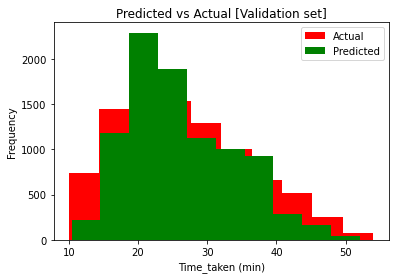

In [22]:
# XGB Regressor
model_xgb_tuned = XGBRegressor(
    n_jobs = -1,
    tree_method = 'gpu_hist',
    predictor = 'gpu_predictor'
)
parameter_space = {
    "n_estimators" : [10, 100, 500],
    "learning_rate" : [0.01, 0.001, 0.0001],
    "max_depth" : [0 , 4, 6, 8],
    "reg_lambda" : [0, 0.25, 0.5, 0.75, 1],
    "reg_alpha" : [0, 0.25, 0.5, 0.75, 1],
}
best_parameters = hpt_engine.Tune(model_xgb_tuned, parameter_space, X_train, Y_train)
model_xgb_tuned.set_params(**best_parameters)
model_xgb_tuned.fit(X_train,Y_train)
predictions = model_xgb_tuned.predict(X_val)
print(f"R^2 score {r2_score(Y_val,predictions)}")
metric_tracker.logMetric(
    "XGB Regressor with parameter tuning (n_estimator, learning_rate, max_depth, lambda, alpha) + "+variant, 
    r2_score(Y_val,predictions), 
    mean_squared_error(Y_val,predictions, squared=False), 
    mean_absolute_error(Y_val,predictions))
plt.ylabel('Frequency')
plt.xlabel('Time_taken (min)')
plt.title("Predicted vs Actual [Validation set]")
plt.hist(Y_val, bins = 10,color='red')
plt.hist(predictions, bins = 10, color='green')
plt.legend(['Actual','Predicted'], loc='upper right')
plt.show()
predictions = model_xgb_tuned.predict(X_test)
preprocessing_engine.generate_submission_file(predictions,"XGB Regressor with parameter tuning (n_estimator, learning_rate, max_depth, lambda, alpha) + "+variant+'.csv')

In [23]:
# # Support Vector Machine Regressor
# model_svr_tuned = SVR()

# parameter_space = {
#     "kernel" :  ["linear", "poly", "rbf", "sigmoid"],
#     "C" : [i for i in np.linspace(0,1,5)],
#     "epsilon" : [i for i in np.linspace(0,1,5)]

# }
# best_parameters = hpt_engine.Tune(model_svr_tuned, parameter_space, X_train, Y_train)
# model_svr_tuned.set_params(**best_parameters)

# model_svr_tuned.fit(X_train, Y_train)
# predictions = model_svr_tuned.predict(X_val)
# print(f"R^2 score {r2_score(Y_val,predictions)}")
# metric_tracker.logMetric(
#     "Support Vector Machine Regressor parameter tuned (kernel, C and epsilon) + "+variant, 
#     r2_score(Y_val,predictions), 
#     mean_squared_error(Y_val,predictions, squared=False), 
#     mean_absolute_error(Y_val,predictions))
# plt.ylabel('Frequency')
# plt.xlabel('Time_taken (min)')
# plt.title("Predicted vs Actual [Validation set]")
# plt.hist(Y_val, bins = 10,color='red')
# plt.hist(predictions, bins = 10, color='green')
# plt.legend(['Actual','Predicted'], loc='upper right')
# plt.show()
# predictions = model_svr_tuned.predict(X_test)
# preprocessing_engine.generate_submission_file(predictions,"Support Vector Machine Regressor parameter tuned (kernel, C, epsilon) + "+variant+".csv")

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(X_train.shape[-1], activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='relu')
])

model.compile(optimizer='adam', loss='mse',metrics=['mse','mae'])
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [25]:
metric_tracker.saveLog()